In [26]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
import matplotlib.pylab as plt
from pathlib import Path
from tensorflow.keras import layers
import json

In [2]:
model_name_it = "VGG_Scratch_jose.h5"

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("No GPU device found")

In [4]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40, min_delta=0.01)

In [5]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss', 
                                                verbose=0,save_best_only=True,
                                                save_weights_only=True,
                                                mode='min')

In [6]:
def scheduler(epoch, lr):
    if epoch%40 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [7]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [8]:
generator = ImageDataGenerator(validation_split=0.2, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

In [9]:
bs = 32 # batch size

In [10]:
path = Path("../dataset/")

In [11]:
img_height = 224
img_width = 224

In [12]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades", 
                 "3_clubs","3_diamonds","3_hearts","3_spades",
                 "4_clubs","4_diamonds","4_hearts","4_spades",
                 "5_clubs","5_diamonds","5_hearts","5_spades", 
                 "6_clubs","6_diamonds","6_hearts","6_spades",
                 "7_clubs","7_diamonds","7_hearts","7_spades",
                 "8_clubs","8_diamonds","8_hearts","8_spades", 
                 "9_clubs","9_diamonds","9_hearts","9_spades",
                 "10_clubs","10_diamonds","10_hearts","10_spades", 
                 "ace_clubs","ace_diamonds","ace_hearts","ace_spades",
                 "jack_clubs","jack_diamonds","jack_hearts","jack_spades",
                 "king_clubs","king_diamonds","king_hearts","king_spades",
                 "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [13]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [14]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


Defining the model

In [15]:
trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

In [16]:
if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'

In [17]:
print(weigths_value)
print(include_top_flag)
print(trainable_flag)

None
True
True


In [19]:
base_model = tf.keras.applications.VGG16(
    weights=weigths_value,
    input_tensor=None,
    pooling=None,
    classifier_activation="softmax",
    input_shape=(img_height, img_width, 3),
    include_top=include_top_flag,
    classes=len(classes_names) )
base_model.trainable = trainable_flag
inputs = layers.Input(shape=(img_height,img_width,3))
outputs = base_model(inputs)
model = tf.keras.Model( inputs,  outputs)

In [20]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 52)                134473588 
                                                                 
Total params: 134,473,588
Trainable params: 134,473,588
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.5e-4), #1e-4
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
history_it = model.fit(train_generator, epochs=17, verbose = 1, 
                       workers=8, validation_data = (validation_generator),
                       callbacks= [monitor_it,early_stop, lr_schedule])

Epoch 1/17
780/780 [==============================] - 314s 394ms/step - loss: 2.9286 - accuracy: 0.1821 - val_loss: 2.6361 - val_accuracy: 0.1610 - lr: 5.0000e-05
Epoch 2/17
780/780 [==============================] - 310s 397ms/step - loss: 1.2558 - accuracy: 0.5915 - val_loss: 2.0611 - val_accuracy: 0.3211 - lr: 5.0000e-05
Epoch 3/17
780/780 [==============================] - 311s 398ms/step - loss: 0.6594 - accuracy: 0.7882 - val_loss: 1.9689 - val_accuracy: 0.3933 - lr: 5.0000e-05
Epoch 4/17
780/780 [==============================] - 310s 397ms/step - loss: 0.3744 - accuracy: 0.8823 - val_loss: 2.0554 - val_accuracy: 0.4642 - lr: 5.0000e-05
Epoch 5/17
780/780 [==============================] - 310s 398ms/step - loss: 0.2336 - accuracy: 0.9300 - val_loss: 2.1324 - val_accuracy: 0.4931 - lr: 5.0000e-05
Epoch 6/17
780/780 [==============================] - 310s 397ms/step - loss: 0.1700 - accuracy: 0.9516 - val_loss: 2.4785 - val_accuracy: 0.5058 - lr: 5.0000e-05
Epoch 7/17
780/780 [==

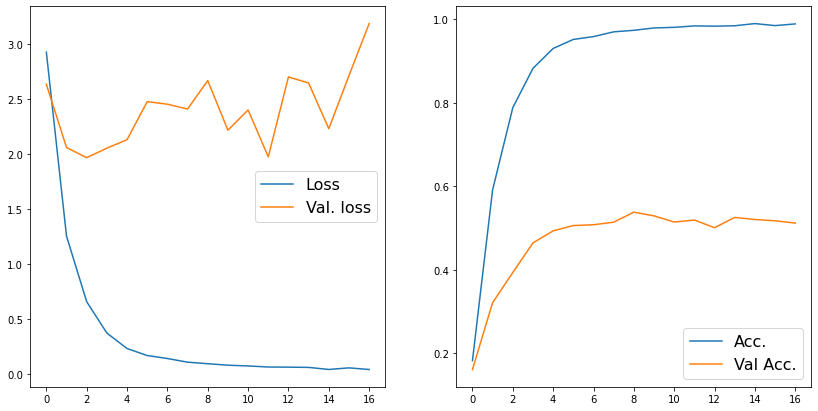

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

axes[0].plot(history_it.history["loss"], label = "Loss")
axes[0].plot(history_it.history["val_loss"], label = "Val. loss")

axes[0].legend(prop={'size': 16})

axes[1].plot(history_it.history["accuracy"], label = "Acc.")
axes[1].plot(history_it.history["val_accuracy"], label = "Val Acc.")

axes[1].legend(prop={'size': 16})

plt.show()

In [29]:
np.save('VGG16_best_model_history.npy', history_it.history)

In [28]:
model.save_weights('VGG16_best_model.h5')

In [30]:
json_config = model.to_json()
with open('VGG16_best_model.json', 'w') as outfile:
    json.dump(json_config, outfile,indent=4)